# Lecture 5: Classical Test Problems for Broyden-Type Methods
### Advanced Programming for Data Science
**Instructor:** Dr. Mansi Singh
**Duration:** 2 hours (28.10.25)

---

## Introduction

In this lecture, we discuss two historically important nonlinear systems used to test **Broyden-type quasi-Newton methods**:

1. **Discrete Integral Equation (IE) problem**  
2. **Discrete Boundary Value Problem (BVP)**

These benchmark problems were widely used in early studies on quasi-Newton and Broyden methods to evaluate:
- Convergence rate,
- Numerical stability,
- Sensitivity to the initial Jacobian approximation,
- Efficiency compared to Newton’s method.

We will:
- Look at the discrete systems,
- Implement them in Python,
- Apply Newton and Broyden-type solvers,
- Observe and compare convergence behavior.


---

## 🔹 Motivation

When developing iterative solvers for nonlinear systems:
$$
f(x) = 0, \quad f: \mathbb{R}^n \to \mathbb{R}^n,
$$
it is important to test their **robustness** and **scaling** on standard benchmark problems.

Two widely used examples are:
1. The **Discrete Boundary Value Problem**, which is **stiffer** and **harder to solve** due to its strong nonlinearity.
2. The **Discrete Integral Equation problem**, which is **smooth** and **well-behaved**.

Both are classical in numerical analysis literature (see e.g., *Dennis & Schnabel, Numerical Methods for Unconstrained Optimization and Nonlinear Equations*, 1983).


## 1️⃣ Discrete Boundary Value Problem (BVP)

We now consider the nonlinear boundary value problem in the interval $I = (0,1)$:
$$
u''(t) = a \, (u(t) + t + 1)^3, \qquad u(0) = u(1) = 0.
$$

### Discretization
Let $ h = \frac{1}{d} $ and $ u_i \approx u(ih) $, $ i = 1, \ldots, d-1 $.

Using the central difference approximation:
$$
\frac{u_{i-1} - 2u_i + u_{i+1}}{h^2} - a \, (u_i + t_i + 1)^3 = 0, \quad i = 1, \ldots, d-1,
$$
with boundary conditions $ u_0 = u_{d} = 0 $.

We take $a = 1/2$.

Thus, the nonlinear system of dimension $d-1$ becomes:
$$
f_i(u) = \frac{u_{i-1} - 2u_i + u_{i+1}}{h^2} - a \, (u_i + t_i + 1)^3 = 0
$$
with the unknown vector $[u_1, u_2, ..., u_{d-1}]$.

## 2️⃣ Discrete Integral Equation Problem

We consider the integral equation:
$$
u(t) + a \int_0^1 K(s, t) \, (u(s) + s + 1)^3 \, ds = 0, 
$$
with kernel
$$
K(s,t) = 
\begin{cases}
s(1-t) \qquad s \leq t, \\
t(1-s) \qquad s > t,
\end{cases}
$$
which is discretized to form a system of nonlinear algebraic equations.

### Discretization
Let $ h = \frac{1}{d} $ and $ u_i \approx u(ih) $, $ i = 1, \ldots, d $.

$$
f_i(x) = u_i + a \, h \left(\sum_{j=1}^i \, (1-t_i)t_j \, (u_j + t_j + 1)^3 + \sum_{j=i+1}^d \, t_i(1-t_j) \, (u_j + t_j + 1)^3 \right)  = 0, \quad i = 1, \ldots, d,
$$
We take $a = 1/2$.

### Quadrature rule used

$$ \int_0^1 u(s) \, ds = h \sum_{j=1}^d \, u(s_j). $$


This problem is **smooth** and typically easy for Newton’s and Broyden’s methods.


## ⚙️ Applying Newton and Broyden Methods

We can now use our previously implemented functions:
- `newton(f, x0, J)`
- `broyden_good(f, x0)`
- `broyden_bad(f, x0)`

to compare their convergence on these two systems.

### Expected Observations:
- The **integral equation** problem is smooth — all methods converge rapidly.
- The **BVP** is stiffer — convergence depends heavily on the starting point.


# Exercises

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import time

def broyden_good(F, x0, max_iters=100, tol=1e-9, verbose=False):
    """
    Broyden's 'Good' Method - updates inverse Jacobian directly
    """
    x = x0.copy().astype(float)
    H = np.eye(len(x0))  # Start with identity as inverse Jacobian
    Fx = F(x)
    history = [x.copy()]
    
    for k in range(max_iters):
        # Calculate the Newton-like step
        s = -H @ Fx
        x_new = x + s
        
        # Evaluate function at new point
        Fx_new = F(x_new)
        
        # Store history
        history.append(x_new.copy())
        
        # Check for convergence
        norm_F = np.linalg.norm(Fx_new)
        if verbose:
            print(f"Iteration {k}: x = {x_new}, F(x) norm = {norm_F:.2e}")
            
        if norm_F < tol:
            break
            
        # Compute the change in F
        y = Fx_new - Fx
        
        # Broyden's "Good" Update
        Hy = H @ y
        denominator = y.T @ y
        
        if np.abs(denominator) > 1e-14:
            H = H + np.outer((s - Hy), y) / denominator
        
        # Update for next iteration
        x = x_new
        Fx = Fx_new
        
    return x, history

def broyden_bad(F, x0, max_iters=100, tol=1e-9, verbose=False):
    """
    Broyden's 'Bad' Method - updates Jacobian directly
    """
    x = x0.copy().astype(float)
    B = np.eye(len(x0))  # Start with identity as Jacobian
    Fx = F(x)
    history = [x.copy()]
    
    for k in range(max_iters):
        # Solve the linear system for the step
        try:
            s = np.linalg.solve(B, -Fx)
        except np.linalg.LinAlgError:
            if verbose:
                print(f"Jacobian became singular at iteration {k}")
            break
            
        x_new = x + s
        
        # Evaluate function at new point
        Fx_new = F(x_new)
        
        # Store history
        history.append(x_new.copy())
        
        # Check for convergence
        norm_F = np.linalg.norm(Fx_new)
        if verbose:
            print(f"Iteration {k}: x = {x_new}, F(x) norm = {norm_F:.2e}")
            
        if norm_F < tol:
            break
            
        # Compute the change in F
        y = Fx_new - Fx
        
        # Broyden's "Bad" Update
        Bs = B @ s
        denominator = s.T @ s
        
        if np.abs(denominator) > 1e-14:
            B = B + np.outer((y - Bs), s) / denominator
        
        # Update for next iteration
        x = x_new
        Fx = Fx_new
        
    return x, history
print("ANARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR")

## Exercise 1: Solve the nonlinear system using both good and bad Broyden methods and then compare the performance of both methods with increasing dimension $d$

An n-dimensional test problem:
    $$F_i(x) = x_i^2 - \cos(x_i) - 1 \quad \text{for ~} i = 1,...,d$$

Try $d = 2,5,10,20.$

Take starting point as $(0.5,..., 0.5)$, tolerance as $tol = 10^{-9}$ and max iteration as $maxit = 200$.

**Plot computation time versus dimension in one graph and iterations versus dimension in another.**


Testing n = 2
Broyden Good: 1761655412.9055s, 8 iterations
Broyden Bad:  1761655412.9055s, 8 iterations

Testing n = 5
Broyden Good: 1761655412.9065s, 8 iterations
Broyden Bad:  1761655412.9065s, 8 iterations

Testing n = 10
Broyden Good: 1761655412.9065s, 8 iterations
Broyden Bad:  1761655412.9075s, 8 iterations

Testing n = 20
Broyden Good: 1761655412.9075s, 8 iterations
Broyden Bad:  1761655412.9075s, 8 iterations


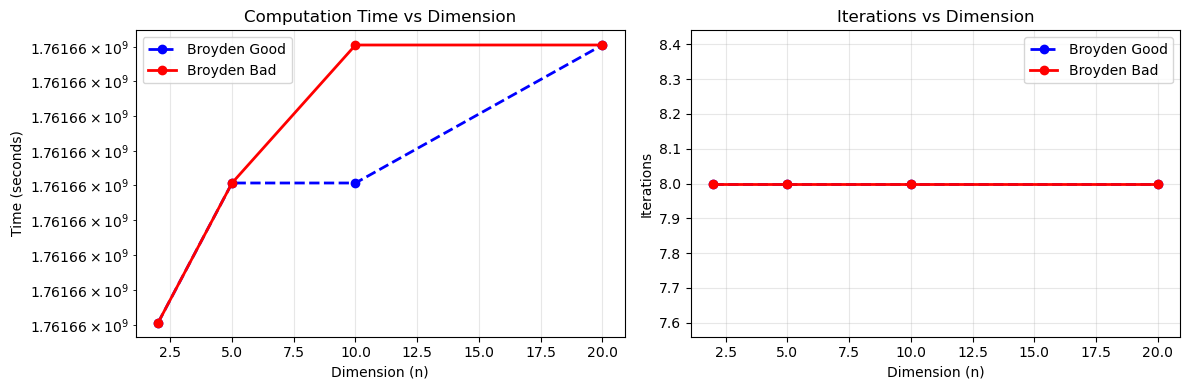

In [5]:
def n_dimensional_problem(x):
    """
    
    """
    return x**2 - np.cos(x) - 1

def performance_comparison():
    dimensions = [2, 5, 10, 20]
    times_good = []
    times_bad = []
    iterations_good = []
    iterations_bad = []
    
    for n in dimensions:
        print(f"\nTesting n = {n}")
        x0 = np.ones(n) * 0.5
        
        # Time Broyden Good
        start = time.process_time()
        sol_good, hist_good = broyden_good(n_dimensional_problem, x0, max_iters=200)
        time_good = time.time() - start
        
        # Time Broyden Bad  
        start = time.process_time()
        sol_bad, hist_bad = broyden_bad(n_dimensional_problem, x0, max_iters=200)
        time_bad = time.time() - start
        
        times_good.append(time_good)
        times_bad.append(time_bad)
        iterations_good.append(len(hist_good))
        iterations_bad.append(len(hist_bad))
        
        print(f"Broyden Good: {time_good:.4f}s, {len(hist_good)} iterations")
        print(f"Broyden Bad:  {time_bad:.4f}s, {len(hist_bad)} iterations")
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.semilogy(dimensions, times_good, 'bo--', label='Broyden Good', linewidth=2)
    plt.semilogy(dimensions, times_bad, 'ro-', label='Broyden Bad', linewidth=2)
    plt.xlabel('Dimension (n)')
    plt.ylabel('Time (seconds)')
    plt.title('Computation Time vs Dimension')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(dimensions, iterations_good, 'bo--', label='Broyden Good', linewidth=2)
    plt.plot(dimensions, iterations_bad, 'ro-', label='Broyden Bad', linewidth=2)
    plt.xlabel('Dimension (n)')
    plt.ylabel('Iterations')
    plt.title('Iterations vs Dimension')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

performance_comparison()

## 📘 Discussion & Further Reading

- Both the **Discrete Integral Equation** and **BVP** problems are used to:
  - Compare convergence rate and robustness of quasi-Newton methods.
  - Test sensitivity to initial guesses and Jacobian approximations.

- The **Integral Equation** problem is well-conditioned; Broyden methods perform similarly to Newton.
- The **BVP** problem is nonlinear and often exhibits slower or non-convergence for bad approximations.

### 🔖 Suggested References
1. Dennis, J. E. & Schnabel, R. B. (1983). *Numerical Methods for Unconstrained Optimization and Nonlinear Equations*. Prentice Hall.
2. Kelley, C. T. (2003). *Solving Nonlinear Equations with Newton's Method*. SIAM.
3. Broyden, C. G. (1965). *A class of methods for solving nonlinear simultaneous equations.* Mathematics of Computation, 19(92):577–593.
4. Nocedal, J. & Wright, S. (2006). *Numerical Optimization*. Springer.

---
